In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
from si_prefix import si_format
import mc_helper

[7.812500000000001e-10, 0]
max allowable error 3.9062500000000003e-10
max error 1.840000000586539e-14
variance of error 1.840000000586539e-14
[63.99997594  0.        ]


/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: divide by zero encountered in log10
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)
/home/madvlsi/dev/git/7-bit-D-A-converter-MP4-MADVLSI/schematics/simulations/mc_helper.py:13: RuntimeWarning: invalid value encountered in scalar remainder
  precision = max(0, sigfigs - np.floor(np.log10(abs(val))) % 3 - 1)


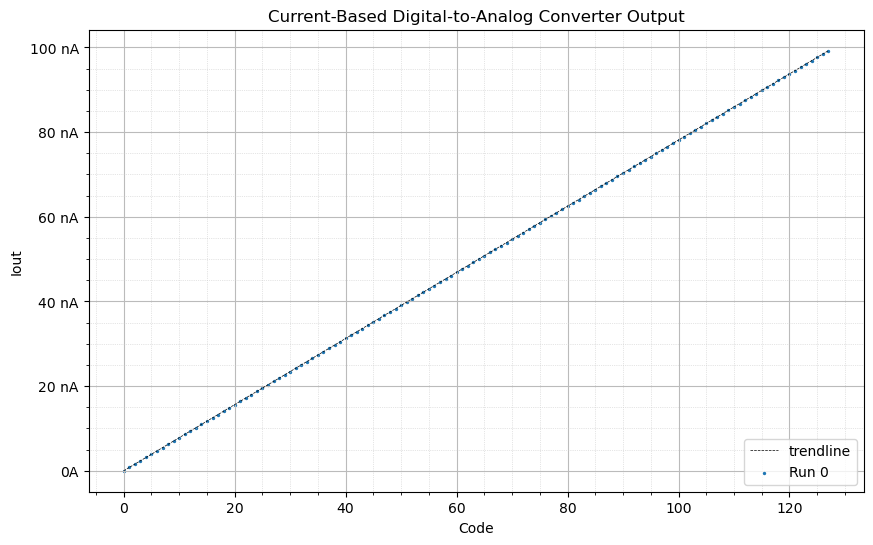

In [22]:
n_bits = 7
mc_simulations = []
results_dir = "ieee_DAC/simulation_results/"
nano = 1e-9
ideal_step_size = (50*nano)/(2**6)


for filename in os.listdir(results_dir):
    df = pd.read_csv(os.path.join(results_dir, filename), delimiter = "\s+")
    # print(df.head(3))

    df["code"] = df["v0"] * 0 # init column to all 0s
    for bit in range(n_bits):
        df["code"] = df["code"] + (df[f"v{bit}"] > .5*df["vdd"]) * 2 ** (n_bits - bit - 1)
        df.drop(f"v{bit}", axis = "columns", inplace = True)
    df.rename({"i(viout)": "Iout"}, axis = "columns", inplace = True)
    # print(df.head(10))

    mc_simulations.append(df)
tdf = pd.concat(mc_simulations)
plt.figure(figsize = (10, 6))
mc_helper.axes_labels("Code", "", "Iout", "A", "Current-Based Digital-to-Analog Converter Output")
mc_helper.make_grids()

#z = np.polyfit(tdf["code"], tdf["Iout"], 1)
z = [ideal_step_size,0]
print(z)
p = np.poly1d(z)

errors = np.subtract(p(tdf["code"]),tdf["Iout"])

print("max allowable error", np.mean( np.subtract( p(range(1,128)) ,p(range(0,127)) ) )/2 )
print("max error",np.max(errors))
print("variance of error",np.max(errors))

dnl  = list(np.multiply(0,list(range(127))))
for df_simulation in mc_simulations:
    sorted = df_simulation.sort_values("code")
    current =   np.subtract(np.divide(
                    np.subtract(
                         list(sorted["Iout"])[1:],list(sorted["Iout"])[:-1]
                    ),ideal_step_size),1)
    print(current)
    cc = list(np.vstack((current,dnl)).T)
    #print(cc)
    for i, line in enumerate(cc):
        dnl[i] = max(line,key=abs)
    print(dnl)

plt.plot(dnl)
print("max overall dnl",max(dnl)) 

plt.plot(range(128),p(range(128)),"k--", label = "trendline", linewidth = .5)

for i, df_simulation in enumerate(mc_simulations):
    # plt.plot(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), linewidth = 1, label = f"Run {i}")
    plt.scatter(np.array(df_simulation["code"]), np.array(df_simulation["Iout"]), s = 2, label = f"Run {i}")
plt.legend(loc = "lower right")